In [1]:
using JLD2, FileIO, Interpolations, DataStructures
using PyPlot
using Samoan, PyPlotPlus

usecmbright()

In [2]:
filepath = joinpath("..", "data", "samoan2012data.jld2")
ctd = load(filepath, "ctd")
vmp = load(filepath, "microstructure")
nvmp = length(vmp)

ctdcast, ctdlon, ctdlat, ctdp, ctdt, ctdsp, ctdsa, ctdsigma4, ctddepth = unpacksection9(ctd)
nz, nctd = size(ctdsigma4);
println("CTD data size: ndepth = $nz, nctd = $nctd. VMP: nvmp = $nvmp")

CTD data size: ndepth = 6001, nctd = 18. VMP: nvmp = 13


In [3]:
# Define density layers
sigmatop = 45.86
sigmabot = 45.96
dsigma = 0.005
layers = sigmatop:dsigma:sigmabot
#layeredges = cat(1, [sigmatop-dsigma/2], layers)
layeredges = cat(1, [sigmatop-dsigma/2], 0.5*(layers[2:end] + layers[1:end-1]), 
    [sigmabot+dsigma/2])
nlayers = length(layers)
println("nlayers = $nlayers")

#layeredges = linspace(sigmatop, sigmabot, nlayers+1)
#layers = 0.5*(layeredges[1:end-1] + layeredges[2:end]);

nlayers = 21


In [4]:
# CTD thickness analysis
ctdthickness = zeros(nlayers, nctd)

for i = 1:nctd
    goodidx = .!isnan.(ctdsigma4[:, i])
    goodsigma = ctdsigma4[goodidx, i]
    gooddepth = ctddepth[goodidx]
    smoothoverturns!(goodsigma)
    
    interpsig = interpolate((goodsigma,), gooddepth, Gridded(Linear()))
    edgedepths = interpsig[layeredges]
    ctdthickness[:, i] = edgedepths[2:end] - edgedepths[1:end-1]   
end

# VMP thickness analysis
layersamples, layerkappa, vmpthickness = vmplayeranalysis(vmp, layeredges)
#@sprintf("max depth: %.2f, mindepth: %.2f", 
#    nanmaximum(vmpedgedepths), nanminimum(vmpedgedepths))

# Mean thickness
   meanthickness = squeeze(nanmean(cat(2, vmpthickness, ctdthickness), 2), 2)
meanvmpthickness = squeeze(nanmean(vmpthickness, 2), 2)
meanctdthickness = squeeze(nanmean(ctdthickness, 2), 2)

 kappa_squeeze = effectivekappa(layerkappa, vmpthickness; pow=1, meanthickness=meanthickness)
kappa_squeeze2 = effectivekappa(layerkappa, vmpthickness; pow=2, meanthickness=meanthickness)
   kappa_naive = squeeze(nanmean(layerkappa, 2), 2)

kappa_scaled = @. layerkappa*meanvmpthickness/vmpthickness

for (i, n) in enumerate(sum(layersamples, 2))
    @printf("sigma: %.5f, mean thickness: %.2f, samples: %d\n", layers[i], meanvmpthickness[i], n)
end
println(median(meanvmpthickness))

sigma: 45.86000, mean thickness: 67.65, samples: 898
sigma: 45.86500, mean thickness: 77.54, samples: 1030
sigma: 45.87000, mean thickness: 76.24, samples: 1009
sigma: 45.87500, mean thickness: 75.48, samples: 1004
sigma: 45.88000, mean thickness: 90.25, samples: 1193
sigma: 45.88500, mean thickness: 73.11, samples: 965
sigma: 45.89000, mean thickness: 74.24, samples: 986
sigma: 45.89500, mean thickness: 77.33, samples: 1019
sigma: 45.90000, mean thickness: 70.07, samples: 928
sigma: 45.90500, mean thickness: 62.37, samples: 827
sigma: 45.91000, mean thickness: 49.43, samples: 649
sigma: 45.91500, mean thickness: 28.86, samples: 383
sigma: 45.92000, mean thickness: 25.02, samples: 331
sigma: 45.92500, mean thickness: 18.77, samples: 250
sigma: 45.93000, mean thickness: 18.61, samples: 249
sigma: 45.93500, mean thickness: 24.09, samples: 322
sigma: 45.94000, mean thickness: 12.91, samples: 171
sigma: 45.94500, mean thickness: 25.41, samples: 341
sigma: 45.95000, mean thickness: 37.58, s

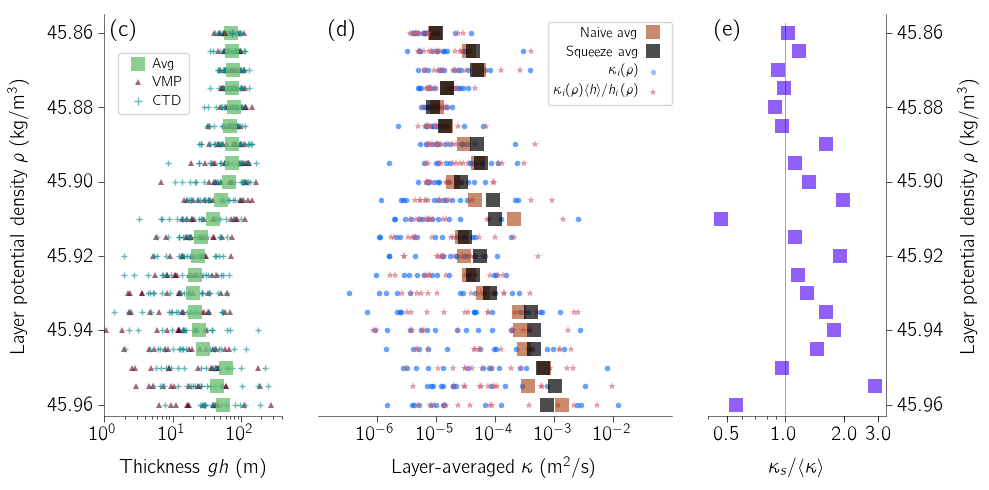

In [5]:
# Plot

## Parameters
      ms0 = 4
      ms1 = 6
      ms2 = 10
    alpha = 0.6
  legsize = 10
xlabelpad = 12.0
    maxms = 10
 vmpcolor = "xkcd:maroon"
 ctdcolor = "xkcd:dark cyan"
vmpsymbol = "^"
ctdsymbol = "+"
xtextpos = 0.03
ytextpos = 0.93
fs = 16

fig, axs = subplots(ncols=3, figsize=(10, 5), sharey=true,  gridspec_kw=Dict("width_ratios"=>[1, 2, 1]))

# Thickness
sca(axs[1])
plot(vmpthickness, layers, vmpsymbol, color=vmpcolor, markeredgecolor="None", alpha=alpha, ms=ms0)
plot(ctdthickness, layers, ctdsymbol, color=ctdcolor, markeredgecolor=ctdcolor, alpha=alpha, ms=ms0)
plot(meanthickness, layers, "s", color="xkcd:soft green", markeredgecolor="None", alpha=0.8, ms=ms2, label="Avg")

# For labeling
plot(vmpthickness[1], layers[1], vmpsymbol, color=vmpcolor, markeredgecolor="None", alpha=alpha, ms=ms0, label="VMP")
plot(ctdthickness[1], layers[1], ctdsymbol, color=ctdcolor, markeredgecolor=ctdcolor, alpha=alpha, ms=ms1, label="CTD")

xscale("log")
xlim(1, 400)
cornerspines()

xticks([1, 10, 100])
xlabel("Thickness \$ g h \$ (m)", labelpad=12.0)
ylabel("Layer potential density \$ \\rho \$ (\$ \\mathrm{kg/m^3} \$)", labelpad=xlabelpad)
legend(loc="upper left", bbox_to_anchor=(0.04, 0.92), 
       prop=Dict("size"=>legsize), markerscale=1.0, markerfirst=true, frameon=true,
       handletextpad=0.05)


# Kappa
sca(axs[2])
scaledms = min.(maxms, @. ms0 * (meanthickness / vmpthickness)^(1/2))
        
plot(layerkappa, layers, "o", color="xkcd:bright blue", markeredgecolor="None", alpha=alpha, ms=ms0)
plot(kappa_scaled, layers, "*", color="xkcd:rose", markeredgecolor="None", alpha=alpha, ms=ms1)
plot(kappa_naive, layers, "s", color="xkcd:rust", markeredgecolor="None", alpha=0.6, ms=ms2, label="Naive avg")
plot(kappa_squeeze, layers, "s", color="xkcd:black", markeredgecolor="None", alpha=0.7, ms=ms2, label="Squeeze avg")

plot(layerkappa[1], layers[1], "o", color="xkcd:bright blue", markeredgecolor="None", alpha=0.4, ms=ms0, 
     label=L"\kappa_i(\rho)")
plot(kappa_scaled[1], layers[1], "*", color="xkcd:rose", markeredgecolor="None", alpha=alpha, ms=ms1, 
     label=L"\kappa_i(\rho) \langle h \rangle / h_i(\rho)")

xscale("log")
xlim(1e-7, 1e-1)
xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
bottomspine()
axs[2][:tick_params](axis="y", which="both", labelleft=false, left=false)
xlabel("Layer-averaged \$ \\kappa \$ (\$ \\mathrm{m^2/s} \$)", labelpad=(xlabelpad-1.5))
legend(loc="upper right", bbox_to_anchor=(1.0, 0.98), 
       prop=Dict("size"=>legsize), markerfirst=false, markerscale=1.0, borderaxespad=0.0, frameon=true, handletextpad=0.05)

# Enhancement
sca(axs[3])
plot(kappa_squeeze./kappa_naive, layers, "s", color="xkcd:purplish blue", markeredgecolor="None", ms=ms2, alpha=0.7, label="2D approx")
plot([1, 1], layeredges[[1, end]], "k-", linewidth=0.5, alpha=0.5)

cornerspines(side="right")
axisright()
xscale("log")
xlim(0.4, 3.3)
xlabel("\$ \\kappa_s / \\langle \\kappa \\rangle \$", labelpad=(xlabelpad+.5))
ylabel("Layer potential density \$ \\rho \$ (\$ \\mathrm{kg/m^3} \$)", labelpad=12.0)

xticks([0.5, 1, 2, 3], [L"\tfrac{1}{2}", "1", "2", "3"])
scalartickformat(:x)

ylim(45.855, 45.963)
invertaxis()

text(xtextpos, ytextpos, "(c)", transform=axs[1][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtextpos, ytextpos, "(d)", transform=axs[2][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtextpos, ytextpos, "(e)", transform=axs[3][:transAxes], ha="left", va="bottom", fontsize=fs)

tight_layout(w_pad=2.0)

plotname = "samoanresults.png"
savefig(plotname, dpi=960)

In [7]:
cp(plotname, joinpath("..", "draft", plotname), remove_destination=true)